# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

You will be marked for your code presentation, design, results, and report. Please note this notebook should take no more than 10 minutes to run on lab computers. 

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [2]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

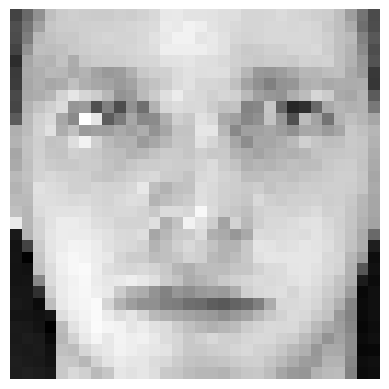

In [4]:
# Display a single example.
show_single_face(data[0, :])

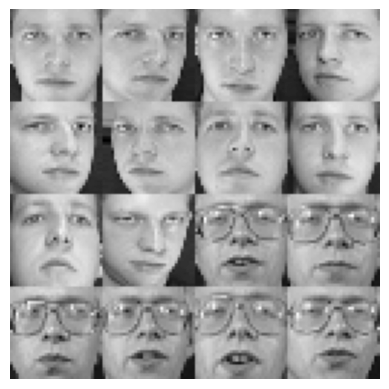

In [5]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [3]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (5 marks, Normal)
### 3.1 Implementation
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [44]:
def l2_rls_train(data, labels, lmbd):
    """
    Trains a linear model using L2-regularized least squares.

    data: (n_samples, n_features) array-like
        The training input samples.

    labels: (n_samples, n_targets) array-like
        The target values for the training input samples.

    lmbd: float
        Regularization parameter.

    Returns: (n_features + 1, n_targets) ndarray
        The learned weights for the linear model.
    """
    
        # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    # X_tilde = ...
    
    # Add a column of ones to the data matrix.
    #X_tilde = np.hstack((np.ones((len(data), 1), dtype=np.float64), data))
    X_tilde = np.hstack([np.ones((data.shape[0], 1)), data])

    # Compute the coefficient vector using L2-regularized least squares.
    if lmbd == 0:
        w = np.linalg.pinv(X_tilde) @ labels
    else:
        w = np.linalg.inv((X_tilde.T @ X_tilde) + (lmbd * np.eye(X_tilde.shape[1]))) @ X_tilde.T @ labels

    return w


Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [45]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """

    # Expand the input data with a column of ones.
    X_tilde = np.hstack([np.ones((data.shape[0], 1)), data])

    # Compute the prediction for the input samples.
    predicted_y = X_tilde @ w

    return predicted_y
        

### 3.2 Report

Explain briefly the knowledge supporting your implementation and your design step by step. Explicitly comment on the role of any arguments you have added to your functions. 

## 4. Face Recognition (4 Marks, Normal)
### 4.1 Implementation and experiment design

Use your implemented functions to perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [46]:
# Your code goes here
# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Split data into training and test sets
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

# print(tr_label)
# encode labels
le = LabelEncoder()
tr_label_enc = le.fit_transform(tr_label)
te_label_enc = le.transform(te_label)
enc = OneHotEncoder()
tr_label_onehot = enc.fit_transform(tr_label.reshape(-1, 1))
te_label_onehot = enc.transform(te_label.reshape(-1, 1))
#print(tr_label_onehot)


# Train and select hyperparameter lambda
lambdas = np.logspace(-4, 4, 9)
#print(lambdas)
best_lambda = None
best_acc = 0
for lmbd in lambdas:
    w = l2_rls_train(tr_data, tr_label_onehot, lmbd)
    predicted_y = l2_rls_predict(w, te_data)
    acc = np.mean(np.argmax(predicted_y, axis=1) == te_label_enc)
    #print(acc)
    if acc > best_acc:
        best_lambda = lmbd
        best_acc = acc
        
#print(best_lambda)        
# Evaluate classifier with selected lambda
w = l2_rls_train(tr_data, tr_label_onehot, best_lambda)
predictions = l2_rls_predict(w, te_data)
conf_mat = confusion_matrix(te_label_enc, np.argmax(predictions, axis=1))


0.915
0.915
0.91
0.915
0.93
0.91
0.835
0.73
0.24
1.0


 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

/home/coder/uni/Comp24112/lab2/lab3lib.py:51: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(img_grid, cmap='gray')


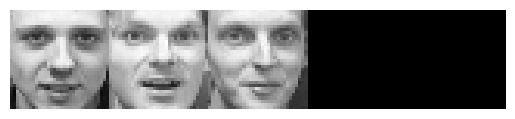

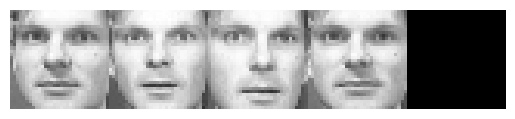

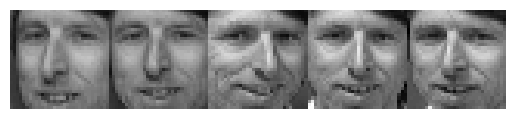

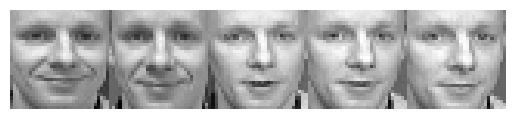

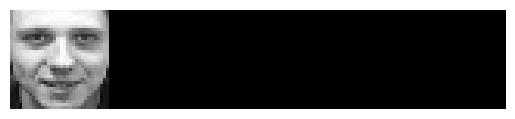

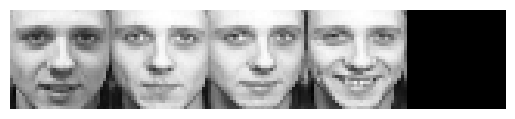

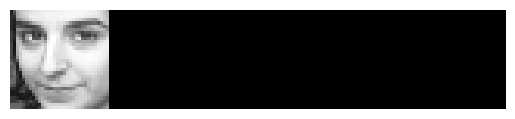

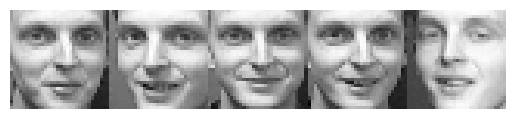

In [47]:
# Your code goes here
# Find subjects with highest and lowest accuracy
acc_per_subject = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
easiest_subjects = np.argsort(acc_per_subject)[-5:]
most_difficult_subjects = np.argsort(acc_per_subject)[:5]

# Show test images for easiest subjects
for subject in easiest_subjects:
    subject_inds = np.where(te_label_enc == subject)[0]
    correct_inds = np.where(np.argmax(predicted_y, axis=1) == subject)[0]
    incorrect_inds = np.setdiff1d(subject_inds, correct_inds)
    show_faces(te_data[correct_inds, :], num_per_row=5, h=32, w=32)
    show_faces(te_data[incorrect_inds, :], num_per_row=5, h=32, w=32)
    

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

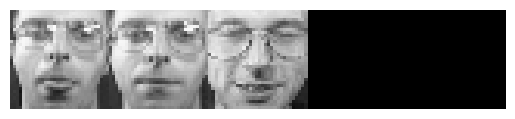

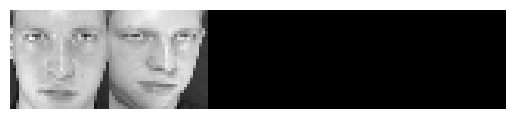

In [48]:
# Your code goes here
# Show misclassified test images for most difficult subjects
for subject in most_difficult_subjects:
    subject_inds = np.where(te_label_enc == subject)[0]
    incorrect_inds = np.where(np.argmax(predicted_y, axis=1) == subject)[0]
    show_faces(te_data[incorrect_inds, :], num_per_row=5, h=32, w=32)

### 4.2 Report

Explain the classification steps, and report your chosen hyper-parameter and results on the test set. Did you notice any common features among the easiest and most difficult subjects to classify? Describe your observations and analyse your results.

## 5. Face Completion (4 Marks, Normal)
In this task you will predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [9]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

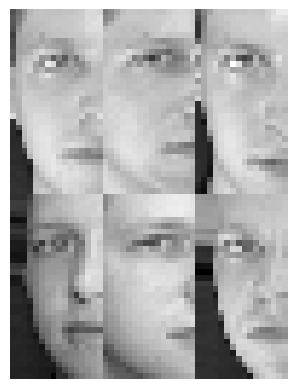

In [14]:
show_split_faces(left[:6, :], num_per_row=3)

### 5.1 Implementation and experiment design

Build a face completion model using your regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [13]:
# Your code goes here
from sklearn.model_selection import train_test_split

# Split the data into left and right halves
tr_ind, te_ind = partition_data(labels, num_per_class=5)
left, right = split_left_right(data[tr_ind, :])
teLeft, teRight = split_left_right(data[te_ind, :])

# Train the model using regularized least squares regression with lambda=0
w = l2_rls_train(left, right, 0)

# Predict the right halves of the faces in the testing set
pred = l2_rls_predict(w, teLeft)

mape = np.mean(np.abs((teRight - pred)/teRight))*100
print(f"MAPE: {mape}%")



MAPE: 23.259541036914896%


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

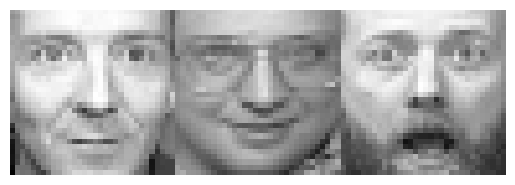

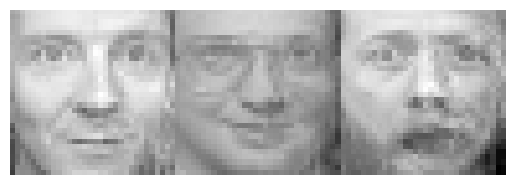

In [61]:
# Select 3 random testing samples
random_indices = np.random.choice(teLeft.shape[0], 3, replace=False)

# Get the left and right parts of the randomly selected samples
teLeft_rand = teLeft[random_indices]
teRight_rand = teRight[random_indices]

# Get the corresponding ground truth faces
gtFaces_rand = join_left_right(teLeft_rand, teRight_rand)

# Get the completed faces for the randomly selected samples
pred_rand = pred[random_indices]
completed_faces_rand = join_left_right(teLeft_rand, pred_rand)

# Display the ground truth faces and completed faces
show_faces(gtFaces_rand, num_per_row=3)
show_faces(completed_faces_rand, num_per_row=3)


### 5.2 Report

Report the MAPE and make some observations regarding the results of the face completion model. How well has your model performed? Offer one suggestion for how it can be improved.


## 6. Training linear least squares model via gradient descent (5 marks, Normal)
For these experiments you will be performing **binary classification.** 
### 6.1 GD Implementation
Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [14]:
import math

def lls_gd_train(data, labels, N, eta):
    """
    Trains a single-output linear model by minimising the sum of squares loss using
    the gradient descent approach.

    data: numpy array of shape (num_samples, num_features) representing the input data.
    labels: numpy array of shape (num_samples,) representing the target labels.
    N: number of iterations.
    eta: learning rate.

    Returns:
    - cost_all: numpy array of shape (N,) representing the cost of linear least squares model calculated in all the iterations.
    - w_all: numpy array of shape (N, num_features + 1) representing the weights of linear least squares model calculated in all the iterations.
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])
    
    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((N, X_tilde.shape[1]))
    cost_all = np.zeros(N)
    
    # GD update of weights
    for i in range(N):
        
        # Compute the gradient of the cost function with respect to the weights
        #grad = 2*np.dot(X_tilde.T, np.dot(X_tilde, w) - y)
        grad = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
        
        # Compute the cost function
        cost = np.mean((np.dot(X_tilde, w) - y)**2)
        #cost = 0.5 * np.sum(np.power(np.dot(X_tilde, w) - y, 2))
        if math.isinf(cost):
            break
        
        # Update the weights
        w = w - eta*grad
        
        # Save the weights and cost at each iteration
        w_all[i,:] = w
        cost_all[i] = cost
    
    # Return the weights and cost at each iteration
    return cost_all, w_all


### 6.2 Experiments

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it runs. 

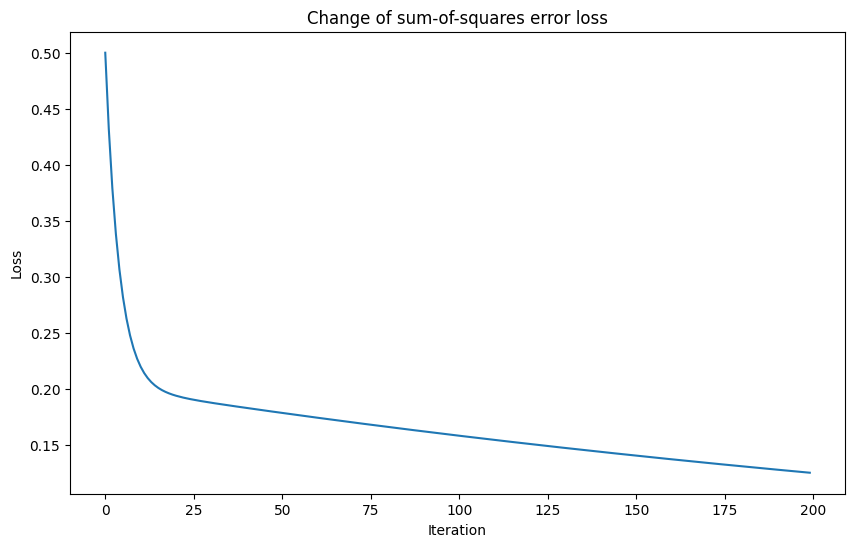

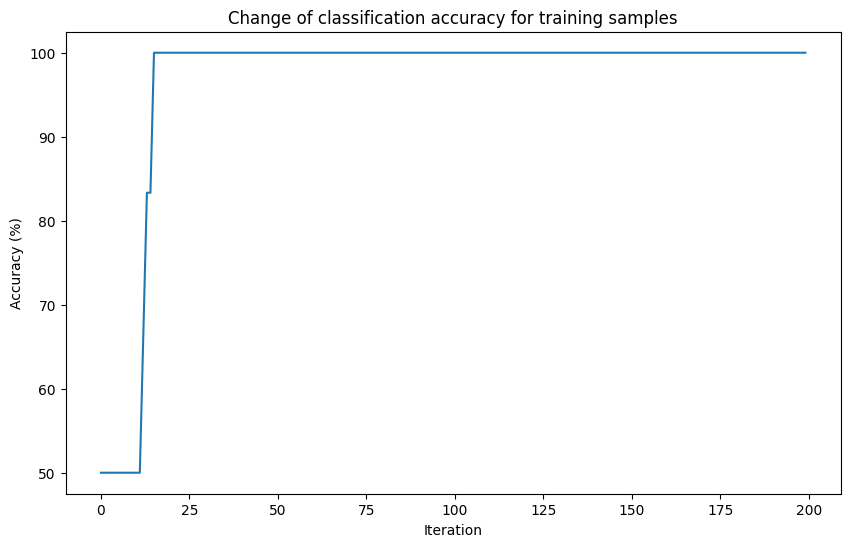

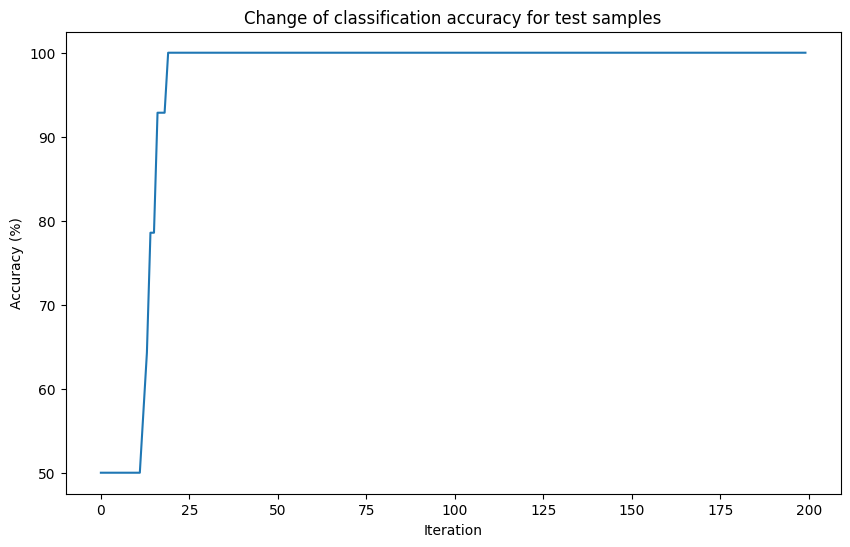

In [22]:
import math
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Your code goes here
data1 = data[labels == 1,:]
data30 = data[labels == 30,:]

# partition
tr_data = np.concatenate((data1[:3], data30[:3]), axis=0)
tr_label = np.concatenate((np.ones(3),np.zeros(3)), axis=0)
te_data = np.concatenate((data1[3:], data30[3:]), axis=0)
te_label = np.concatenate((np.ones(7),np.zeros(7)), axis=0)

# Train the model using gradient descent
N = 200
eta = 1e-9
cost_all, w_all = lls_gd_train(tr_data, tr_label, N, eta)

testChange = []; trainChange = [];


for w in w_all:
    # Make predictions on test data
    test_preds = l2_rls_predict(w, te_data)
    test_binary_preds = (test_preds >= 0.5).astype(int)
    test_accuracy = accuracy_score(te_label, test_binary_preds) * 100
    testChange.append(test_accuracy)
    
    # Make predictions on training data
    train_preds = l2_rls_predict(w, tr_data)
    train_binary_preds = (train_preds >= 0.5).astype(int)
    train_accuracy = accuracy_score(tr_label, train_binary_preds) * 100
    trainChange.append(train_accuracy)
       

# Plot the change of sum-of-squares error loss
plt.figure(figsize=(10, 6))
plt.plot(cost_all)
plt.title('Change of sum-of-squares error loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Plot the change of classification accuracy for training samples
plt.figure(figsize=(10, 6))
plt.plot(trainChange)
plt.title('Change of classification accuracy for training samples')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.show()

# Plot the change of classification accuracy for test samples
plt.figure(figsize=(10, 6))
plt.plot(testChange)
plt.title('Change of classification accuracy for test samples')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.show()
    




Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it runs. 

/tmp/ipykernel_4039/29428136.py:39: RuntimeWarning: overflow encountered in square
  cost = np.mean((np.dot(X_tilde, w) - y)**2)


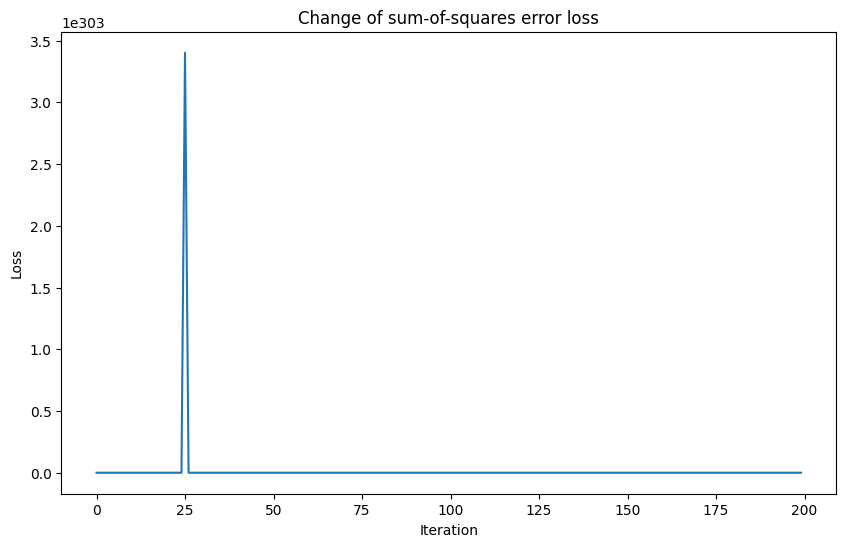

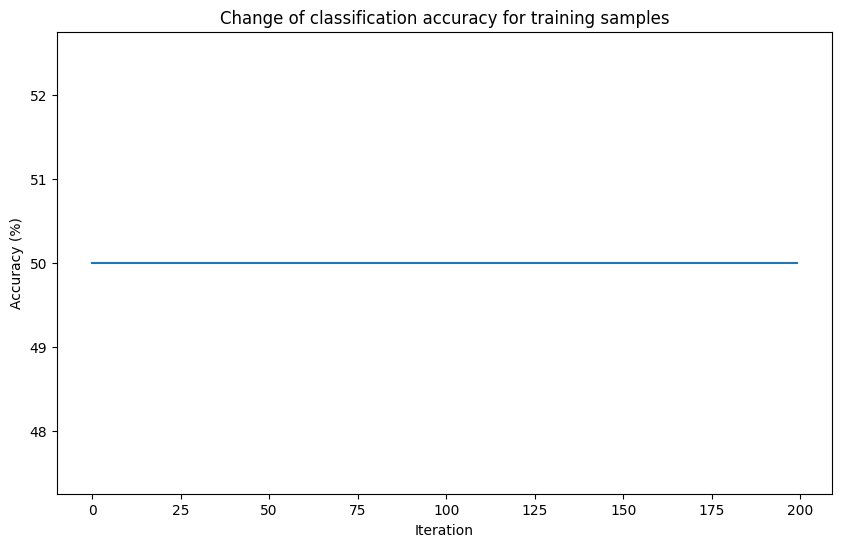

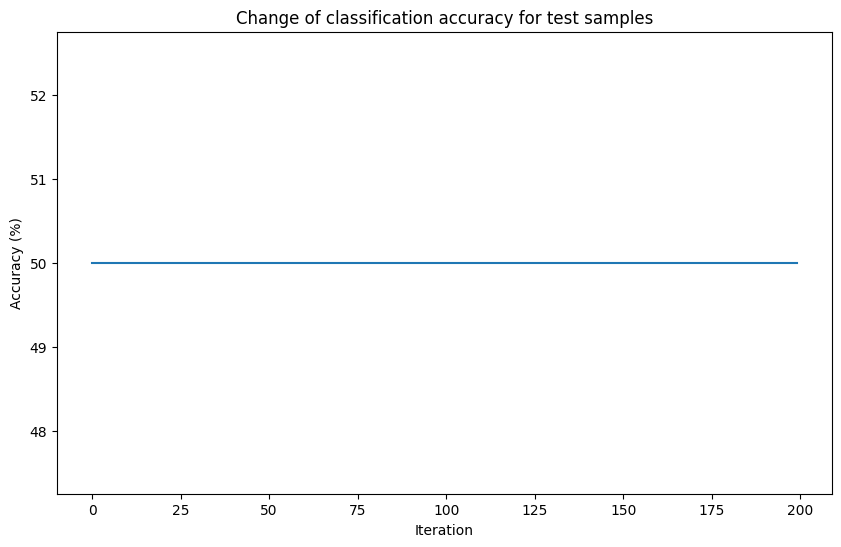

In [21]:
# Your code goes here
# Train the model using gradient descent
N = 200
eta = 1e-2
cost_all, w_all = lls_gd_train(tr_data, tr_label, N, eta)

testChange = []; trainChange = [];

for w in w_all:
    # Make predictions on test data
    test_preds = l2_rls_predict(w, te_data)
    test_binary_preds = (test_preds >= 0.5).astype(int)
    test_accuracy = accuracy_score(te_label, test_binary_preds) * 100
    testChange.append(test_accuracy)
    
    # Make predictions on training data
    train_preds = l2_rls_predict(w, tr_data)
    train_binary_preds = (train_preds >= 0.5).astype(int)
    train_accuracy = accuracy_score(tr_label, train_binary_preds) * 100
    trainChange.append(train_accuracy)
    


# Plot the change of sum-of-squares error loss
plt.figure(figsize=(10, 6))
plt.plot(cost_all)
plt.title('Change of sum-of-squares error loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Plot the change of classification accuracy for training samples
plt.figure(figsize=(10, 6))
plt.plot(trainChange)
plt.title('Change of classification accuracy for training samples')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.show()

# Plot the change of classification accuracy for test samples
plt.figure(figsize=(10, 6))
plt.plot(testChange)
plt.title('Change of classification accuracy for test samples')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.show()

### 6.3 Report

How did you choose the learning rate and iteration number? Explain your results.

## 7. Advanced Gradient-based Training
For this section, you may choose to implement **either Option 1: SGD** (4 marks), or **Option 2: GD with hinge loss** (7 marks). 

*Please note: Option 1 is easier, but gives fewer potential marks. Option 2 is designed to be a steep challenge, potentially involves mathematical derivations not shown in your notes, and will be marked rigorously. Choose wisely!*

### Option 1: Compare with stochastic gradient descent training (4 marks, Normal)
### 7.1 SGD Implementation 
Replace the gradient descent approach that you did in Section 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt a similar implementation template to that of your `lls_gd_train` function.

In [26]:
# Your code goes here

def lls_sgd_train(data, labels, N, eta):
    """
    Trains a single-output linear model by minimising the sum of squares loss using
    the stochastic gradient descent approach.

    data: numpy array of shape (num_samples, num_features) representing the input data.
    labels: numpy array of shape (num_samples,) representing the target labels.
    N: number of iterations.
    eta: learning rate.

    Returns:
   
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])
    
    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((N, X_tilde.shape[1]))
    cost_all = np.zeros(N)
    
    # SGD update of weights
    for i in range(N):
        
        # Randomly select a sample from the training set
        sample = np.random.randint(X_tilde.shape[0])
        x_i = X_tilde[sample,:]
        y_i = y[sample]
        
        # Compute the gradient of the cost function with respect to the weights using that sample
        grad = 2*np.dot(x_i.T, np.dot(x_i, w) - y_i)
      
        # Compute the cost function using that sample
        cost = (np.dot(x_i, w) - y_i)**2
        
        if math.isinf(cost):
            break
        
        # Update the weights using that sample
        w = w - eta*grad
        
        # Save the weights and cost at each iteration
        w_all[i,:] = w
        cost_all[i] = cost
    
    # Return the weights and cost at each iteration
    return cost_all, w_all



### 7.2 Experiment Design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference between gradient descent and stochastic gradient descent. 


Learning rate: 1e-06
Test MSE for GD: 158.3634
Test MSE for SGD: 470.1779
Convergence time for GD: 0.9790 seconds
Convergence time for SGD: 0.0000 seconds


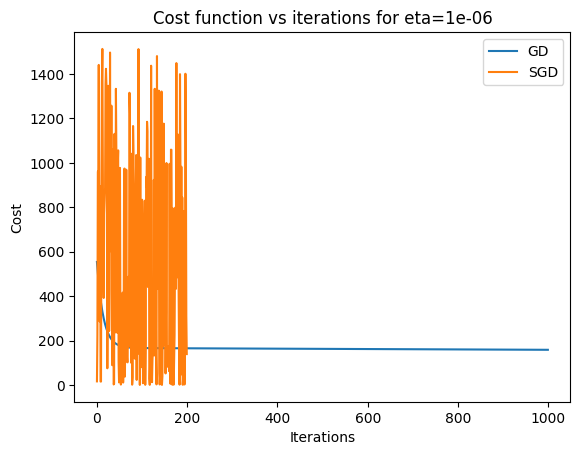

Learning rate: 0.01
Test MSE for GD: 553.5000
Test MSE for SGD: 11572339481410036967633254878127685719867843271826553747172672070141096329751206073794248191468649491502981222926074508446939395460241778478810059802109538465280414646168897344132082824808615116592714087851872547553949084922524987441390746919958590734786399518058700865536.0000
Convergence time for GD: 0.0600 seconds
Convergence time for SGD: 0.0000 seconds


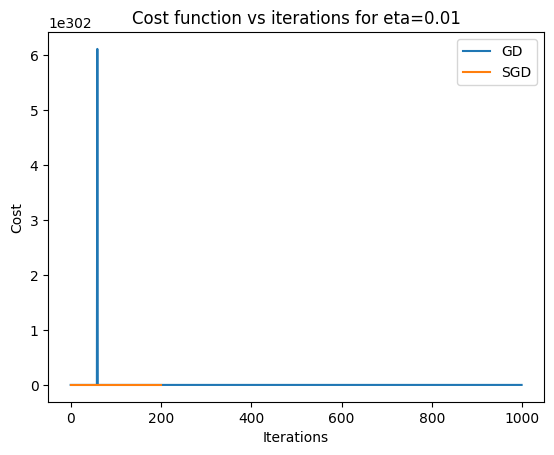

/tmp/ipykernel_4039/683511485.py:42: RuntimeWarning: overflow encountered in double_scalars
  cost = (np.dot(x_i, w) - y_i)**2


Learning rate: 0.1
Test MSE for GD: 553.5000
Test MSE for SGD: 553.5000
Convergence time for GD: 0.0430 seconds
Convergence time for SGD: 0.0890 seconds


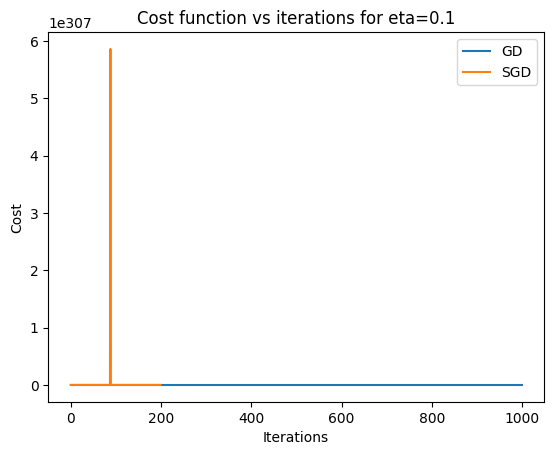

In [35]:
# Your code goes here
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

data, labels = load_data()

# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

# loss function
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def convergence_time(cost_all, threshold):
    # Find the first iteration where the cost is below the threshold
    ind = np.where(cost_all < threshold)[0][0]
    return ind * 0.001 

# Train linear regression model using GD and SGD
N = 1000 # number of iterations for GD
N2 = 200 # number of epochs for SGD
eta_values = [0.000001, 0.01, 0.1]  # learning rates to try

# Loop over different learning rates
for eta in eta_values:
    # Train using GD
    cost_gd, w_gd = lls_gd_train(tr_data, tr_label, N, eta)
    # Train using SGD
    cost_sgd, w_sgd = lls_sgd_train(tr_data, tr_label, N2, eta)
    
    # Evaluate on test data
    y_pred_gd = np.dot(np.hstack((np.ones((te_data.shape[0], 1)), te_data)), w_gd[-1])
    y_pred_sgd = np.dot(np.hstack((np.ones((te_data.shape[0], 1)), te_data)), w_sgd[-1])
    
    # Compute test MSE
    mse_gd = mse(te_label, y_pred_gd)
    mse_sgd = mse(te_label, y_pred_sgd)
    
    # Compute convergence time
    time_gd = convergence_time(cost_gd, mse_gd)
    time_sgd = convergence_time(cost_sgd, mse_sgd)
    
    # Print results
    print(f"Learning rate: {eta}")
    print(f"Test MSE for GD: {mse_gd:.4f}")
    print(f"Test MSE for SGD: {mse_sgd:.4f}")
    print(f"Convergence time for GD: {time_gd:.4f} seconds")
    print(f"Convergence time for SGD: {time_sgd:.4f} seconds")
    
    # Plot cost function vs iterations
    plt.plot(cost_gd, label="GD")
    plt.plot(cost_sgd, label="SGD")
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.title(f"Cost function vs iterations for eta={eta}")
    plt.legend()
    plt.show()

### 7.3 Report

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

**Remember that all graphs should have axis labels and a title.**

### Option 2: Gradient descent training using hinge loss (7 marks, Hard)
Here is a recap of Hinge loss. For a single output model, the hinge loss over N training samples is $$O(\theta) = \sum^N_{i=1}\max\left(0, 1 - y_i f(\theta, x_i)\right)$$ where $y_i \in \{-1, +1\}$ is the class target label and $f(\theta, x_i)$ is your prediction function. While this is not directly differentiable, we can split it into two separately differentiable parts. For one sample, the above formuation is equivalent to:
$$
\max\left(0, 1 - y_i f(\theta, x_i)\right) = \begin{cases}
    0 & \text{if } y_i f(\theta, x_i) \geq 1 \\ % & is your "\tab"-like command (it's a tab alignment character)
    1-y_i f(\theta, x_i) & \text{otherwise.}
\end{cases}
$$

### 7.1 Implementation
Apply the gradient descent approach to train your classifier but by minimising the hinge loss. Implement the function `hinge_gd_train` below. 

`hinge_gd_train` trains a single-output linear model by minimising the hinge loss using the gradient descent approach. The optimisation function should include a regularisation term and regularisation hyperparameter $C$. It should take the iteration number $N$, the learning rate $\eta$, and regularisation hyperparameter $C$ as arguments. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of the regularised hinge loss model calculated in all the iterations.

In [20]:
def hinge_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Initialise arrays to store weights and cost at each iteration
    w_all = ...
    cost_all = ...

    # Your code goes here
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear hinge loss model
        cost = ...
        
        # save w and cost of each iteration in w_all and cost_all


    # Return model parameters.
    return cost_all, w_all


### 7.2 Experiment design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference for gradient descent training based on the least squared loss and the hinge loss. 


In [21]:
# Your code goes here

### 7.3 Report

Explain in your report the following: 

(1) Your implementation of `hinge_gd_train`. If you analytically derived the loss function, please include it here.

(2) Your experiment design, comparative result analysis and interpretation of obtained results. 

**Remember that all graphs should have axis labels and a title.**